# Using Density Estimation to Find Antigens with Differential Responses

Here we will work with the dataset that contains measurements of antibody responses to a panel of 214 immunoreactive antigens in sera from 87 melioidosis positive and 59 meliotidis negative patients in Singapore. Our goal is to identify immunoreactive antigens that have the most different responses between positive and negative samples (patients). The idea (heuristics) presented in the book

> Yang, Zheng Rong. Machine learning approaches to bioinformatics. Vol. 4. World Scientific, 2010

is the following. 

1. Separate positive and negative samples.
2. Separately for positive and negative samples, normalize the measurements for each antigen.
3. Using PCA, map the normalized data (separately positive and negative) into two dimensions according to the first two principal components.
4. Separately for positive and negative samples, use the transformed 2D data to estimate density using Gaussian kernel density estimation. Two log-density estimations are obtained.
5. Interpret the density as the likelihood of obtaining the (2D) data. Compute PCA differential score for each antigen.
6. Find antigens with the highest differential score as candidates for antigens that can be used to distinguish positive and negative samples.


## Loading the Data

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os

In [209]:
BURKHOLDERIA_DATA_URL = 'http://ksvi.mff.cuni.cz/~mraz/bioinf/Materialy/burkholderia' 
BHLD_DATA_PATH = 'Burkholderia_data'

import os
from six.moves import urllib

def fetch_data(source_data_filename,local_data_filename,data_url, local_dir):
    # Store file with the file name source_data_filename at url data_url
    # into the file local_data_filename in a local directory local_dir
    # do that only if the file does not exists in the local_dir.
    if not os.path.isdir(local_dir):
        os.makedirs(local_dir)
    data_path = os.path.join(local_dir, local_data_filename)
    print("datapath",data_path)
    if not os.path.exists(data_path):
        urllib.request.urlretrieve(data_url+'/'+source_data_filename, data_path)
        print('Data have been downloaded')
    else:
        print('No download, data have been found already at a local disk')

In [210]:
fetch_data('burkholderia_pseudomallei','Burkholderia_pseudomallei.csv',BURKHOLDERIA_DATA_URL,BHLD_DATA_PATH)

datapath Burkholderia_data/Burkholderia_pseudomallei.csv
No download, data have been found already at a local disk


We suppose that data file is in a subdirectory `BHLD_DATA_PATH = 'Burkholderia_data'` and its name is `Burkholderia_pseudomallei.csv`. We read the data and display the first 5 rows of the table. 

In [211]:
data_orig = pd.read_csv(os.path.join(BHLD_DATA_PATH,'Burkholderia_pseudomallei.csv'),header=0,sep='\t')

print('data_orig shape:',data_orig.shape)
data_orig.head()

data_orig shape: (146, 215)


,BPSS1512,BPSL2520,BPSL2522,BPSS1525,BPSS1516,BPSL2096,BPSS1722,BPSS2141,BPSL2698,BPSS0476,...,BPSS1998,BPSS2277,BPSL0606,BPSS0226,BPSS1401,BPSL0361,BPSS0796.2,BPSS1382,BPSS0412,Target
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,333.50,0.0,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0
1,10.33,162.33,132.33,50.33,64.33,0.00,135.33,682.33,0.0,13.33,...,146.33,59.33,0.0,0.0,0.00,0.0,0.0,0.0,60.33,0
2,0.00,0.00,2173.33,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0
3,0.00,534.83,474.83,0.00,0.00,336.83,0.00,673.83,0.0,0.00,...,0.00,0.00,0.0,0.0,126.83,0.0,0.0,0.0,0.00,0
4,5558.33,422.33,156.33,0.00,0.00,0.00,108.33,0.00,0.0,386.33,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0


Each row of the table corresponds to one patient (sample). Each of the first 214 columns contains responses to one immunoreactive antigen. The last column indicates whether the patient was melioidosis positive (value `0`) or negative (value `1`). 

Next, we extract negative samples.

In [212]:
noninfected_orig = data_orig[data_orig.Target==1]
print('noninfected_orig shape:',noninfected_orig.shape)
print(noninfected_orig.head())
noninfected_orig.describe()

noninfected_orig shape: (59, 215)
    BPSS1512  BPSL2520  BPSL2522  BPSS1525  BPSS1516  BPSL2096  BPSS1722  \
87       0.0      0.00      0.00       0.0       0.0       0.0       0.0   
88       0.0      0.00      0.00       0.0       0.0       0.0       0.0   
89       0.0      0.00    139.67       0.0       0.0       0.0       0.0   
90     543.0      0.00      0.00       0.0       0.0       0.0       0.0   
91       0.0    568.67      0.00       0.0       0.0       0.0       0.0   

    BPSS2141  BPSL2698  BPSS0476  ...  BPSS1998  BPSS2277  BPSL0606  BPSS0226  \
87       0.0      0.00      0.00  ...       0.0      0.00      0.00       0.0   
88       0.0      0.00     96.33  ...       0.0      0.00      0.00       0.0   
89       0.0      0.00    355.67  ...       0.0      0.00     25.67       0.0   
90       0.0      0.00      0.00  ...       0.0      0.00      0.00    4680.0   
91       0.0    116.67      0.00  ...       0.0   5588.67    509.67       0.0   

    BPSS1401  BPSL0361

,BPSS1512,BPSL2520,BPSL2522,BPSS1525,BPSS1516,BPSL2096,BPSS1722,BPSS2141,BPSL2698,BPSS0476,...,BPSS1998,BPSS2277,BPSL0606,BPSS0226,BPSS1401,BPSL0361,BPSS0796.2,BPSS1382,BPSS0412,Target
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,1992.392881,1201.438136,400.056610,37.632542,913.966271,155.997119,1425.048136,417.890169,726.093051,652.296271,...,97.683729,392.652712,97.073559,598.559322,105.118644,359.090339,402.358814,318.186441,1.810678,1.0
std,5292.340168,1537.205426,709.456577,162.087534,2614.641375,861.466748,2818.626107,1350.736171,2634.472282,2567.937023,...,628.783889,1103.086446,285.678718,2814.418981,757.359249,2012.230246,1288.264151,1893.747694,13.908081,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,298.170000,532.670000,116.330000,0.000000,0.000000,0.000000,395.830000,0.000000,0.000000,47.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,1714.420000,1690.750000,500.080000,0.000000,545.415000,0.000000,1102.585000,47.420000,144.085000,283.920000,...,0.000000,26.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,38097.670000,6265.500000,3522.170000,1049.330000,16897.500000,6568.000000,15455.170000,9535.670000,18219.830000,18743.830000,...,4795.500000,5588.670000,1802.330000,18714.500000,5819.500000,14926.830000,7271.500000,14358.500000,106.830000,1.0


In [213]:
# drop the target column
noninfected = noninfected_orig.drop("Target",axis=1)
print("noninfected_orig shape",noninfected_orig.shape)
print("noninfected shape",noninfected.shape)

noninfected_orig shape (59, 215)
noninfected shape (59, 214)


Now, one row corresponds to the data of one noninfected patient.

Next, we extract positive samples.

In [214]:
infected_orig = data_orig[data_orig.Target==0]
print('infected_orig shape:',infected_orig.shape)
print(infected_orig.head())
infected_orig.describe()

infected_orig shape: (87, 215)
   BPSS1512  BPSL2520  BPSL2522  BPSS1525  BPSS1516  BPSL2096  BPSS1722  \
0      0.00      0.00      0.00      0.00      0.00      0.00      0.00   
1     10.33    162.33    132.33     50.33     64.33      0.00    135.33   
2      0.00      0.00   2173.33      0.00      0.00      0.00      0.00   
3      0.00    534.83    474.83      0.00      0.00    336.83      0.00   
4   5558.33    422.33    156.33      0.00      0.00      0.00    108.33   

   BPSS2141  BPSL2698  BPSS0476  ...  BPSS1998  BPSS2277  BPSL0606  BPSS0226  \
0    333.50       0.0      0.00  ...      0.00      0.00       0.0       0.0   
1    682.33       0.0     13.33  ...    146.33     59.33       0.0       0.0   
2      0.00       0.0      0.00  ...      0.00      0.00       0.0       0.0   
3    673.83       0.0      0.00  ...      0.00      0.00       0.0       0.0   
4      0.00       0.0    386.33  ...      0.00      0.00       0.0       0.0   

   BPSS1401  BPSL0361  BPSS0796.2  BP

,BPSS1512,BPSL2520,BPSL2522,BPSS1525,BPSS1516,BPSL2096,BPSS1722,BPSS2141,BPSL2698,BPSS0476,...,BPSS1998,BPSS2277,BPSL0606,BPSS0226,BPSS1401,BPSL0361,BPSS0796.2,BPSS1382,BPSS0412,Target
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,...,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.0
mean,36128.718276,19795.057241,15648.494138,11288.112759,10431.062989,9703.936552,9273.898276,7649.459885,6334.149195,5939.177931,...,230.883218,214.193448,195.107241,165.174253,164.768046,104.492299,77.277701,72.323678,3.429080,0.0
std,25612.979707,22406.200785,19977.507792,19130.438542,16349.811947,12963.334105,13157.282690,12124.231074,11406.860706,10965.615102,...,1045.618769,694.358976,725.402266,1000.539008,526.878659,811.493085,472.819529,502.252571,19.710866,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,4439.165000,754.915000,1117.915000,0.000000,32.165000,0.000000,256.835000,0.000000,0.000000,6.665000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,50733.670000,7349.830000,4293.500000,0.000000,1804.330000,2865.170000,2210.330000,2638.500000,1421.000000,1297.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,59162.085000,37940.920000,25324.085000,13157.165000,12626.165000,16598.000000,14763.330000,8303.835000,5037.665000,6506.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,63639.500000,61150.170000,61007.000000,60151.330000,61211.830000,53783.330000,55374.330000,57352.330000,49895.000000,55197.000000,...,7523.170000,3928.830000,4253.670000,8407.830000,2616.000000,7396.830000,4058.000000,4539.830000,154.170000,0.0


In [215]:
infected = infected_orig.drop("Target",axis=1)
print("infected_orig shape",infected_orig.shape)
print("infected shape",infected.shape)

infected_orig shape (87, 215)
infected shape (87, 214)


## PCA and Visualization of the Data

We are now interested in different immunoreactive antigens, that is, one observation is the list of responses to one antigen. Therefore we transpose our tables.

In [216]:
noninfectedT = noninfected.T
infectedT = infected.T
noninfectedT.head()

,87,88,89,90,91,92,93,94,95,96,...,136,137,138,139,140,141,142,143,144,145
BPSS1512,0.0,0.0,0.00,543.0,0.00,0.0,0.00,118.17,6.5,0.0,...,3313.0,875.83,2837.67,2877.67,0.00,5944.33,347.5,2978.5,8.83,38097.67
BPSL2520,0.0,0.0,0.00,0.0,568.67,0.0,0.00,0.00,337.5,0.0,...,1495.0,1606.83,3926.67,2679.67,1243.17,5807.33,931.5,4600.5,272.83,3241.67
BPSL2522,0.0,0.0,139.67,0.0,0.00,0.0,557.33,1022.17,37.5,0.0,...,1267.0,1069.83,0.00,0.00,229.17,293.33,301.5,0.0,787.83,0.00
BPSS1525,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,253.5,0.0,0.00,0.00
BPSS1516,0.0,0.0,0.00,0.0,0.00,0.0,574.33,0.00,0.0,0.0,...,0.0,1195.83,0.00,936.67,127.17,9075.33,16897.5,3939.5,0.00,3176.67


For visualization (and further computations) we map the tables using the first two principal components (`n_components=2`) obtained from Principal Component Analysis (PCA)

In [217]:
from sklearn.decomposition import PCA

%matplotlib inline

pca_infected = PCA(n_components=2)
pos2D = pca_infected.fit_transform(infectedT)

pca_noninfected = PCA(n_components=2)
neg2D = pca_noninfected.fit_transform(noninfectedT)

The index of the table `infectedT` is the list of the names of antigens. These are the same for both tables `infectedT` and `noninfectedT`.

In [218]:
desc = list(infectedT.index)
desc[:10]

['BPSS1512',
 'BPSL2520',
 'BPSL2522',
 'BPSS1525',
 'BPSS1516',
 'BPSL2096',
 'BPSS1722',
 'BPSS2141',
 'BPSL2698',
 'BPSS0476']

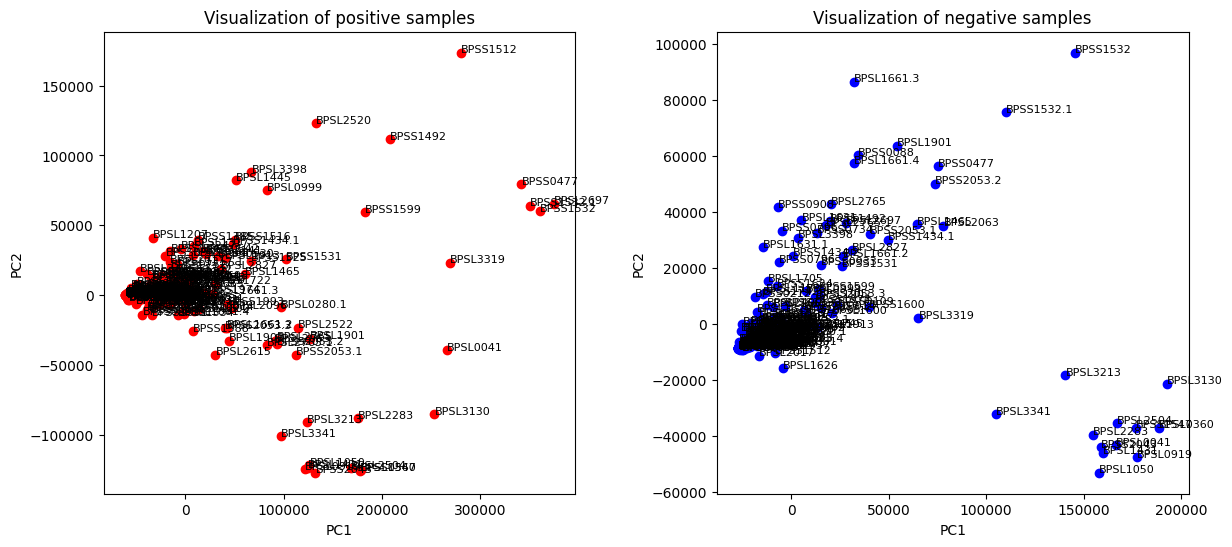

In [219]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def visualizePCA(fig,subplot,x,y,names,ttl,names_offset=0.1,c='r'):
    ax = fig.add_subplot(subplot,title=ttl,xlabel="PC1",ylabel="PC2")
    for i,d in enumerate(names):
        ax.text(x[i]+names_offset,y[i]+names_offset,d,fontsize=8)
    ax.scatter(x,y,c=c)
    
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)
visualizePCA(fig,121,pos2D[:,0],pos2D[:,1],desc,c="r",ttl="Visualization of positive samples")
visualizePCA(fig,122,neg2D[:,0],neg2D[:,1],desc,c="b",ttl="Visualization of negative samples")

plt.draw()

Note that the corresponding axes in the two subplots have very different ranges. Let us first normalize the data and redo the visualization. This step is not explained in the book 

>    Yang, Zheng Rong. Machine learning approaches to bioinformatics. Vol. 4. World Scientific, 2010

Probably it was done in order to obtain higher values for the density estimators.

In [220]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

std_scaler_neg = StandardScaler()
std_scaler_neg.fit(noninfectedT)
noninfectedT_std = std_scaler_neg.transform(noninfectedT)
print("noninfectedT_std shape",noninfectedT_std.shape)

noninfectedT_std shape (214, 59)


In [221]:
std_scaler_pos = StandardScaler()
std_scaler_pos.fit(infectedT)
infectedT_std = std_scaler_pos.transform(infectedT)
print("infectedT_std shape",infectedT_std.shape)

infectedT_std shape (214, 87)


In [222]:
pca_infected_std = PCA(n_components=2)
pos2D_std = pca_infected_std.fit_transform(infectedT_std)

pca_noninfected_std = PCA(n_components=2)
neg2D_std = pca_noninfected_std.fit_transform(noninfectedT_std)

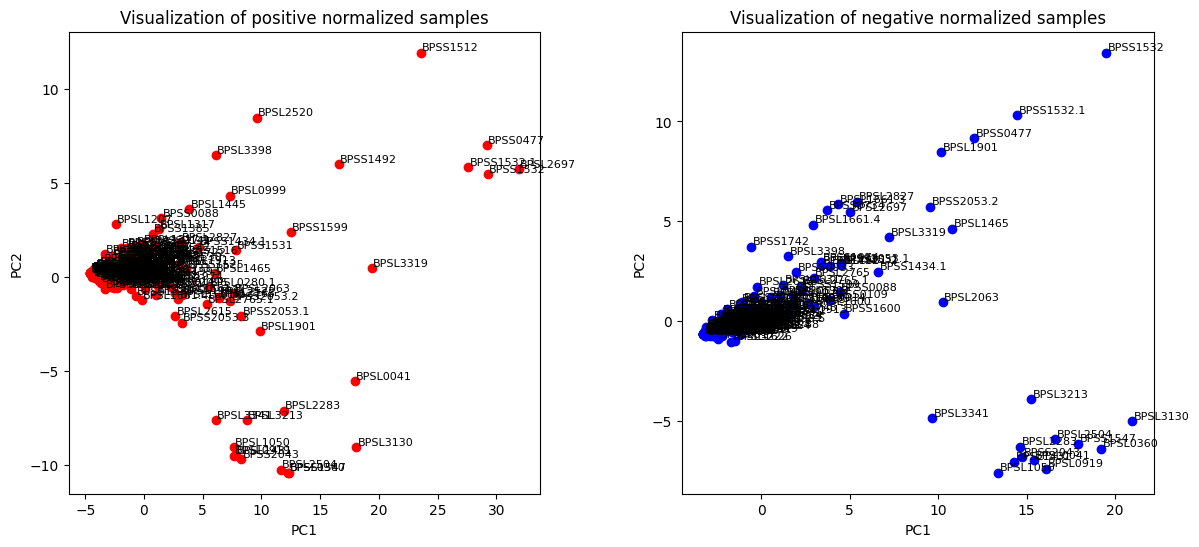

In [223]:
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)
visualizePCA(fig,121,pos2D_std[:,0],pos2D_std[:,1],desc,c="r",ttl="Visualization of positive normalized samples")
visualizePCA(fig,122,neg2D_std[:,0],neg2D_std[:,1],desc,c="b",ttl="Visualization of negative normalized samples")

plt.draw()

The `PCA` object has many attributes. Among them are the principal components (the eigenvectors of the covariance matrix) and corresponding eigenvalues: 

* `components_` are the principal components,
* `singular_values_` are the 2-norms of the variables in the lower-dimensional space (in our case, the eigenvalues),
* `explained_variance_` is the amount of variance explained by each of the principal components; it equals the list of n_components largest eigenvalues of the covariance matrix of data, and 
* `explained_variance_ratio_` is the proportion of variance explained by the corresponding principal component.

In [224]:
print("Eigenvalues:\n",pca_infected_std.singular_values_,"\n","_"*20)
print("Principal components:\n",pca_infected_std.components_,"\n","_"*20)
print("Explained variance:\n",pca_infected_std.explained_variance_,"\n","_"*20)
print("Explained variance ratio:\n",pca_infected_std.explained_variance_ratio_,"\n","_"*20)

Eigenvalues:
 [94.87628479 39.47868022] 
 ____________________
Principal components:
 [[ 0.05880426  0.01854605  0.09782381  0.08240915  0.0999294   0.11020703
   0.10854711  0.09510206  0.10279258  0.10446484  0.07766362  0.09680683
   0.07944978  0.10847143  0.07192924  0.06522847  0.10573795  0.10664963
   0.07324734  0.11921487  0.10129294  0.10700147  0.10183557  0.12051429
   0.0972336   0.11724367  0.09587791  0.07639744  0.11362907  0.12178487
   0.09592015  0.12670271  0.10198849  0.11362785  0.11680575  0.11813802
   0.08868619  0.07719875  0.08713021  0.08793847  0.0905697   0.11495121
   0.08089019  0.11168803  0.1241361   0.12007697  0.11371809  0.12149027
   0.1233333   0.11127748  0.10758852  0.11672398  0.11282755  0.12373431
   0.10964345  0.11784726  0.11246774  0.12293352  0.12408661  0.11440418
   0.11054612  0.10917008  0.10728575  0.12048566  0.11358367  0.11219773
   0.10786779  0.12560725  0.12764322  0.12220992  0.12321243  0.10377346
   0.10645314  0.08925914 

In [225]:
sum(pca_infected_std.explained_variance_ratio_)

0.567197099972358

Hence, for positive data, almost 57% of the information is presented by the first two principal components and 43% is the information loss when we replace the original data by the projected two-dimensional vectors.

In [226]:
pca_noninfected_std.explained_variance_ratio_

array([0.44044154, 0.10297691])

In [227]:
sum(pca_noninfected_std.explained_variance_ratio_)

0.5434184507721743

## Gaussian Kernel Density Estimation

Now we will estimate the density normalized antigen measurements for positive and negative data.

In [228]:
from sklearn.neighbors import KernelDensity

bndw = 1.0/np.sqrt(2)
pos_density = KernelDensity(kernel='gaussian', bandwidth=bndw).fit(pos2D_std)
neg_density = KernelDensity(kernel='gaussian', bandwidth=bndw).fit(neg2D_std)

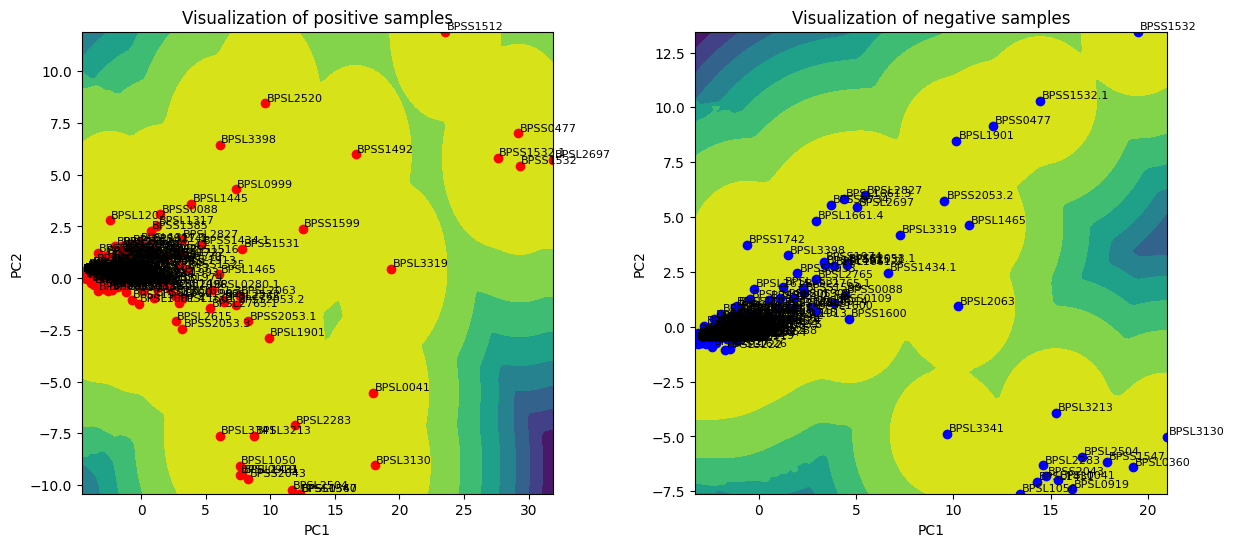

In [229]:
def visualizeDensity(fig,subplot,x,y,density,names,ttl,names_offset=0.1,c='r'):
    res = 100
    xx,yy = np.meshgrid(np.linspace(np.min(x),np.max(x),res), np.linspace(np.min(y),np.max(y),res))
    den = density.score_samples(np.column_stack((xx.ravel(),yy.ravel())))
    den.shape = xx.shape

    ax = fig.add_subplot(subplot,title=ttl,xlabel="PC1",ylabel="PC2")
    ax.contourf(np.linspace(np.min(x),np.max(x),res), np.linspace(np.min(y),np.max(y),res),den)
    for i,d in enumerate(names):
        ax.text(x[i]+names_offset,y[i]+names_offset,d,fontsize=8)
    ax.scatter(x,y,c=c)

    
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)
visualizeDensity(fig,121,pos2D_std[:,0],pos2D_std[:,1],pos_density,desc,c="r",ttl="Visualization of positive samples")
visualizeDensity(fig,122,neg2D_std[:,0],neg2D_std[:,1],neg_density,desc,c="b",ttl="Visualization of negative samples")


## PCA Differential Score

In the estimated density for positive and negative data, each antigene has a likelihood of its measurement. Let us denote the likelihood of measurements for the $i$-th antigene in positive data by $p_i^+$ and the likelihood of measurements for the $i$-th antigene in negative data by $p_i^-$. Then, we define normalized likelihood measurements for positive and negative data as
$$\tilde{p}_i^+ = \frac{p_i^+}{\sum_{i} p_i^+} \qquad \text{and} \qquad \tilde{p}_i^- = \frac{p_i^-}{\sum_{i} p_i^-}.$$
Then the *PCA differential score* can be defined as $$\lambda_i = |\tilde{p}_i^+ - \tilde{p}_i^-|.$$

Next, we will identify the top 10 antigens with the highest PCA differential scores.

In [230]:
pos_sample_logdensity = pos_density.score_samples(pos2D_std)
print("Logdensity of positivesamples\n",pos_sample_logdensity)
print("="*30)
pos_sample_density = np.exp(pos_sample_logdensity)
print("Density of positive samples\n",pos_sample_density)
sum_pos_sample_density = sum(pos_sample_density)
pos_sample_likelihood = pos_sample_density / sum_pos_sample_density
#pos_sample_likelihood = pos_sample_density / np.max(pos_sample_density)
print("Likelihood of positive samples\n",pos_sample_likelihood)

Logdensity of positivesamples
 [-6.5107059  -6.51070583 -5.27947202 -5.46899945 -5.25145336 -4.91029036
 -5.10535785 -4.80050703 -3.90628407 -3.67494407 -3.89250182 -3.57302173
 -5.99676298 -2.36543151 -2.18821973 -2.41603322 -2.15030518 -2.22721505
 -2.20887903 -2.16286206 -2.22445163 -2.17512025 -2.19661951 -2.23120395
 -2.24896256 -2.27561585 -2.28094192 -2.34144859 -2.3751975  -6.50957335
 -6.41245196 -6.5107059  -4.97572256 -3.54946338 -3.47635203 -2.16115329
 -2.23347219 -2.26777378 -2.28025191 -2.27195387 -2.28040547 -2.28699888
 -2.3315414  -2.34894041 -2.35875636 -5.86499315 -6.44274769 -5.27739657
 -2.15535331 -2.34074532 -6.5107059  -6.5083803  -5.54459146 -6.47079771
 -5.53166366 -4.76957072 -5.10094233 -4.62102851 -3.81530702 -3.63201469
 -4.05850122 -3.8818378  -3.48073732 -3.30540431 -3.60684481 -3.94645337
 -6.38373919 -6.44294956 -6.5107059  -6.51070134 -6.51070134 -5.54757116
 -5.53476115 -6.51058994 -5.68768191 -6.46949079 -5.46100507 -6.14811546
 -5.23783716 -5.3606

In [231]:
neg_sample_logdensity = neg_density.score_samples(neg2D_std)
print("Logdensity of negativesamples\n",neg_sample_logdensity)
print("="*30)
neg_sample_density = np.exp(neg_sample_logdensity)
print("Density of negative samples\n",neg_sample_density)
sum_neg_sample_density = sum(neg_sample_density)
neg_sample_likelihood = neg_sample_density / sum_neg_sample_density
#neg_sample_likelihood = neg_sample_density / np.max(neg_sample_density)
print("Likelihood of negative samples\n",neg_sample_likelihood)

Logdensity of negativesamples
 [-2.49306482 -2.2482108  -1.96874553 -2.08548243 -2.03425796 -2.04940806
 -2.69795369 -1.9739791  -2.07702816 -2.06251699 -2.08351497 -1.98885555
 -2.05793635 -1.99445609 -2.08627766 -2.01719727 -2.05762352 -2.07365525
 -2.07079906 -2.0783825  -2.0999793  -2.07120679 -2.09060615 -2.10336073
 -2.08632564 -2.09171968 -2.0862584  -2.09895977 -2.10274465 -5.64610205
 -6.49115007 -5.04883064 -2.30616325 -2.81014084 -2.436563   -2.03283125
 -2.06838273 -2.05886639 -2.05495862 -2.0646718  -2.05161388 -2.06901943
 -2.08245242 -2.07194273 -2.10338951 -6.44924729 -6.50538065 -5.91954541
 -2.18817902 -3.3201923  -4.66552585 -4.53562451 -2.94270675 -3.00062111
 -4.79128324 -2.64337813 -3.06904749 -3.25783058 -2.53501018 -2.96517156
 -2.25882653 -1.97410677 -2.18524978 -1.9600448  -2.0035545  -1.99476545
 -6.5107059  -6.5099726  -6.47379523 -5.44777749 -6.50354406 -6.35737841
 -6.21840921 -5.51908385 -6.19100327 -6.49148741 -5.29292865 -5.2943065
 -5.43529855 -6.11516

In [232]:
PCA_diff_score = abs(pos_sample_likelihood - neg_sample_likelihood)
print(PCA_diff_score[:10])
idx = np.argsort(PCA_diff_score)[::-1]
print(idx[:10])
PCA_diff_score = PCA_diff_score[idx]
desc_PCA_diff_score = [desc[e] for e in list(idx)]
for d,v in zip(desc_PCA_diff_score[:],PCA_diff_score[:]):
    print(d,v)

[0.00468529 0.00602012 0.00769604 0.00687506 0.00716837 0.00687336
 0.00340606 0.00738832 0.00558901 0.00525191]
[ 2  7 12  4  3  5 61 65 49  1]
BPSL2522 0.007696042298169373
BPSS2141 0.007388318376346908
BPSL1207 0.007223550826456564
BPSS1516 0.00716836542908829
BPSS1525 0.006875060802848973
BPSL2096 0.00687335570915117
BPSS1546 0.006337493930091587
BPSS0962 0.006281501230858315
BPSS0796 0.006053401880747964
BPSL2520 0.006020119172641008
BPSL2698 0.005589011527199496
BPSL2030 0.005587089725713372
BPSS1778 0.005549971177190648
BPSS1588 0.005518194527741859
BPSL1631.1 0.0053568605559932885
BPSS0476 0.0052519112133254595
BPSS0530 0.00521505825717686
BPSS1743 0.005089966712835448
BPSL3396 0.00502968306790087
BPSS1845 0.0049135655332191025
BPSS1512 0.004685285614687842
BPSL3247 0.004617274430258132
BPSS2053.6 0.004208508673364865
BPSL1626 0.0040088181749043965
BPSL2017 0.003936667264334551
BPSS0212 0.0036434771921319232
BPSS1993 0.003420865090255394
BPSS1722 0.003406060229918703
BPSL0280 0

Hence, the antigen `BPSL2522` has the maximal PCA differential score (0.007696042298169482). And top 10 differential genes are:

<BarContainer object of 10 artists>

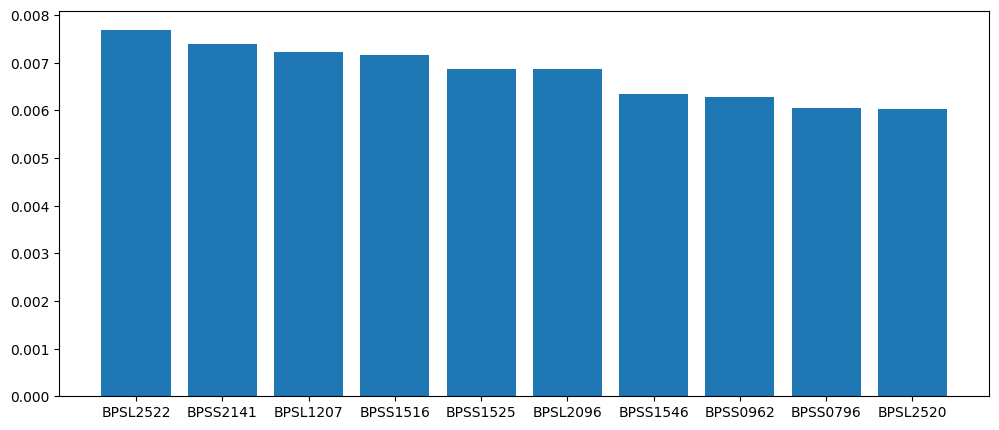

In [233]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(desc_PCA_diff_score[:10],PCA_diff_score[:10])

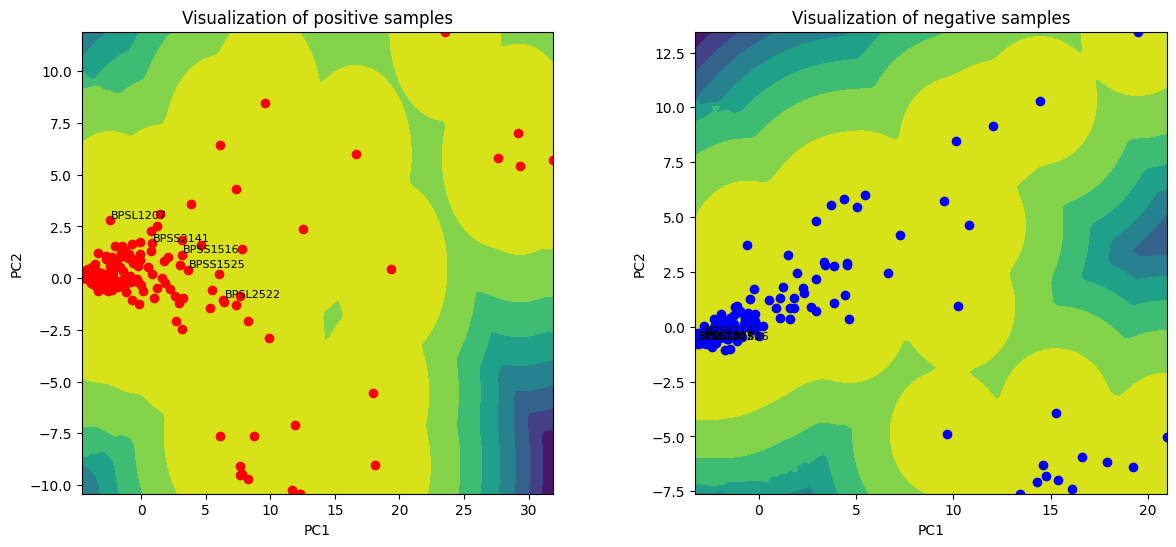

In [234]:
def visualizeDensity_and_PCADiffScore(fig,subplot,x,y,density,names,ttl,names_offset=0.1,c='r'):
    res = 100
    xx,yy = np.meshgrid(np.linspace(np.min(x),np.max(x),res), np.linspace(np.min(y),np.max(y),res))
    den = density.score_samples(np.column_stack((xx.ravel(),yy.ravel())))
    den.shape = xx.shape

    ax = fig.add_subplot(subplot,title=ttl,xlabel="PC1",ylabel="PC2")
    ax.contourf(np.linspace(np.min(x),np.max(x),res), np.linspace(np.min(y),np.max(y),res),den)
    for i,d in enumerate(names[:5]):
        ax.text(x[i]+names_offset,y[i]+names_offset,d,fontsize=8)
    ax.scatter(x,y,c=c)

    
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(wspace=0.3)
visualizeDensity_and_PCADiffScore(fig,121,pos2D_std[idx,0],pos2D_std[idx,1],pos_density,desc_PCA_diff_score,c="r",ttl="Visualization of positive samples")
visualizeDensity_and_PCADiffScore(fig,122,neg2D_std[idx,0],neg2D_std[idx,1],neg_density,desc_PCA_diff_score,c="b",ttl="Visualization of negative samples")


In [235]:
print("The top 5 differential antigens are:", desc_PCA_diff_score[:5])

The top 5 differential antigens are: ['BPSL2522', 'BPSS2141', 'BPSL1207', 'BPSS1516', 'BPSS1525']


## Compute Differential Score Using Other Dimensionality Reduction Methods

Compute the top 10 differential antigens when we use 
1. multi-dimensional scaling (`sklearn.manifold.MDS`), and
2. locally-linear embedding (`sklearn.manifold.LocallyLinearEmbedding(method='standard',n_neighbors=20)`)

for reducing the data (`infectedT_std` and `noninfectedT_std`) into 2D instead of PCA. Are the top 5 differential antigens the same as for PCA?

In [236]:
from sklearn.manifold import MDS, LocallyLinearEmbedding

mds_infected_mds = MDS(n_components=2, random_state=40)
pos2D_mds = mds_infected_mds.fit_transform(infectedT_std)

mds_noninfected_mds = MDS(n_components=2, random_state=40)
neg2D_mds = mds_noninfected_mds.fit_transform(noninfectedT_std)

/Users/diellor/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/diellor/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [237]:
from sklearn.neighbors import KernelDensity

bndw = 1.0/np.sqrt(2)
pos_density = KernelDensity(kernel='gaussian', bandwidth=bndw).fit(pos2D_mds)
neg_density = KernelDensity(kernel='gaussian', bandwidth=bndw).fit(neg2D_mds)

In [238]:
pos_sample_logdensity = pos_density.score_samples(pos2D_mds)
print("Logdensity of positivesamples\n",pos_sample_logdensity)
print("="*30)
pos_sample_density = np.exp(pos_sample_logdensity)
print("Density of positive samples\n",pos_sample_density)
sum_pos_sample_density = sum(pos_sample_density)
pos_sample_likelihood = pos_sample_density / sum_pos_sample_density
#pos_sample_likelihood = pos_sample_density / np.max(pos_sample_density)
print("Likelihood of positive samples\n",pos_sample_likelihood)

Logdensity of positivesamples
 [-6.5107059  -6.51070268 -6.50915277 -6.51017134 -6.45271269 -6.40864516
 -6.45847243 -5.70973409 -5.71353147 -5.8060905  -6.15294175 -5.9591075
 -6.43146798 -3.30524144 -2.97167406 -3.79971025 -3.38477395 -3.03663804
 -2.70588305 -3.29272814 -2.87190803 -2.72689932 -2.63622149 -2.7109059
 -2.59932176 -2.64123676 -2.67729858 -2.70813972 -2.7444158  -6.51070431
 -6.51070431 -6.5107059  -6.23853549 -6.38814118 -4.83017584 -2.69849525
 -2.61489039 -2.66052859 -2.68305078 -2.62461283 -2.61810186 -2.67834427
 -2.68132647 -2.7267341  -2.71034042 -6.50528322 -5.92697668 -5.27078706
 -4.40481326 -5.97526681 -6.51067472 -6.51070587 -6.51036719 -6.51067584
 -6.4531878  -6.50805015 -6.13741206 -5.82701531 -5.77138116 -6.39238639
 -5.8118538  -5.62643931 -5.50283596 -5.31934712 -5.93699414 -6.13863245
 -6.5107044  -6.5107044  -6.5107059  -6.51070135 -6.51070135 -5.56747616
 -5.54965304 -6.5089587  -5.69458938 -6.51067471 -5.39426261 -6.50102936
 -5.19504423 -5.259144

In [239]:
neg_sample_logdensity = neg_density.score_samples(neg2D_mds)
print("Logdensity of negativesamples\n",neg_sample_logdensity)
print("="*30)
neg_sample_density = np.exp(neg_sample_logdensity)
print("Density of negative samples\n",neg_sample_density)
sum_neg_sample_density = sum(neg_sample_density)
neg_sample_likelihood = neg_sample_density / sum_neg_sample_density
#neg_sample_likelihood = neg_sample_density / np.max(neg_sample_density)
print("Likelihood of negative samples\n",neg_sample_likelihood)

Logdensity of negativesamples
 [-5.34838382 -3.66930681 -2.66105896 -2.3774886  -3.65725301 -2.39558262
 -5.91398391 -3.30814269 -5.25931985 -5.35846165 -2.39362223 -3.21032298
 -2.51953977 -2.34513599 -2.37866325 -2.59432362 -2.36775259 -2.38970976
 -2.3659469  -2.38253959 -2.39417265 -2.37303226 -2.38319812 -2.39685444
 -2.38456584 -2.3921589  -2.38302713 -2.39568646 -2.39587911 -6.50662812
 -6.51059788 -6.44954068 -3.67835262 -6.50991492 -4.90401248 -2.36994866
 -2.36014092 -2.42591005 -2.54832273 -2.36633551 -2.35017161 -2.41466258
 -2.37521749 -2.37865558 -2.39688504 -6.5107059  -6.34517329 -6.16951074
 -4.06172906 -5.69720954 -5.72311944 -6.34887061 -5.12981682 -6.27788912
 -5.90258085 -4.3191139  -5.78134254 -5.95848954 -4.13539386 -6.51061883
 -3.84950468 -2.62825058 -2.75253205 -2.42788747 -2.55658263 -3.22101181
 -6.5107059  -6.5107059  -6.5107059  -5.54579343 -6.42891563 -6.2989937
 -6.23574887 -5.67023662 -6.15200649 -6.5107059  -5.38476942 -6.51047943
 -5.51415043 -5.93164

In [240]:
mds_diff_score = abs(pos_sample_likelihood - neg_sample_likelihood)
print(mds_diff_score[:10])
idx = np.argsort(mds_diff_score)[::-1]
print(idx[:10])
mds_diff_score = mds_diff_score[idx]
desc_mds_diff_score = [desc[e] for e in list(idx)]
for d,v in zip(desc_mds_diff_score[:],mds_diff_score[:]):
    print(d,v)

[3.28844329e-04 3.08161970e-03 8.97210256e-03 1.20133376e-02
 3.10460035e-03 1.17601612e-02 3.99249113e-05 4.18237756e-03
 1.88969271e-05 1.30988554e-05]
[  3   5  10 188 210 190 160  63 156  12]
BPSS1525 0.012013337615119968
BPSL2096 0.011760161191933896
BPSS1588 0.011686305391026096
BPSS1850 0.01139047067139162
BPSL0361 0.01138665773485368
BPSS1845 0.01112964343008381
BPSS0564 0.010730781851250907
BPSS1743 0.010715118372455132
BPSL3396 0.010475404428150257
BPSL1207 0.010357644423096963
BPSS0226 0.010342129951135579
BPSL1925 0.010279051202951464
BPSL0007 0.010124583878047114
BPSL0814 0.01007899764601013
BPSS1778 0.009759679124143212
BPSL2522 0.008972102564247483
BPSS1394 0.008877624673465406
BPSS1546 0.008852089300470357
BPSS0839 0.008346400373071203
BPSS0467 0.007856259655257164
BPSL2017 0.007635635289463035
BPSL3228 0.007475841152164839
BPSS0212 0.007288392014245688
BPSS1594 0.006990381762015811
BPSL1629 0.006951089869935972
BPSL2752 0.006528453413105351
BPSS2053.6 0.006038611192020

<BarContainer object of 10 artists>

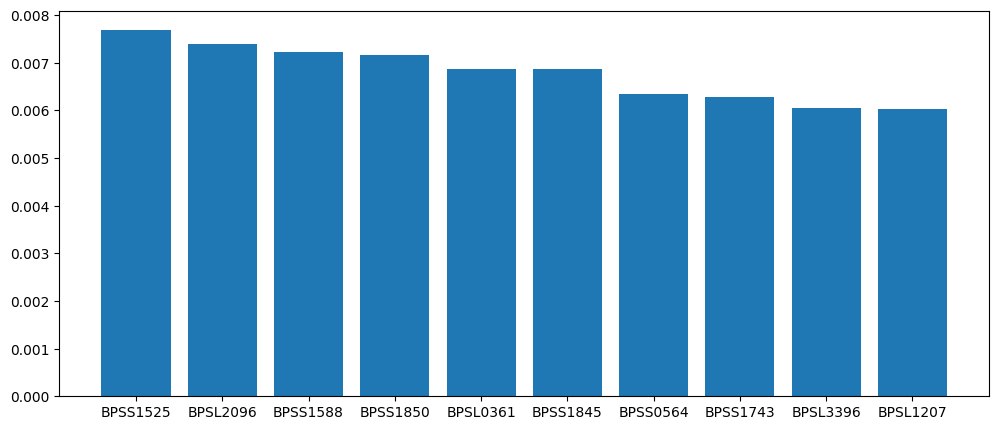

In [241]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(desc_mds_diff_score[:10],PCA_diff_score[:10])

In [242]:
lle_infected_lle = LocallyLinearEmbedding(n_components=2, method='standard', n_neighbors=20)
pos2D_lle = lle_infected_lle.fit_transform(infectedT_std)

lle_noninfected_lle = LocallyLinearEmbedding(n_components=2, method='standard', n_neighbors=20)
neg2D_lle = lle_noninfected_lle.fit_transform(noninfectedT_std)

In [243]:
from sklearn.neighbors import KernelDensity

bndw = 1.0/np.sqrt(2)
pos_density = KernelDensity(kernel='gaussian', bandwidth=bndw).fit(pos2D_lle)
neg_density = KernelDensity(kernel='gaussian', bandwidth=bndw).fit(neg2D_lle)

In [244]:
pos_sample_logdensity = pos_density.score_samples(pos2D_lle)
print("Logdensity of positivesamples\n",pos_sample_logdensity)
print("="*30)
pos_sample_density = np.exp(pos_sample_logdensity)
print("Density of positive samples\n",pos_sample_density)
sum_pos_sample_density = sum(pos_sample_density)
pos_sample_likelihood = pos_sample_density / sum_pos_sample_density
#pos_sample_likelihood = pos_sample_density / np.max(pos_sample_density)
print("Likelihood of positive samples\n",pos_sample_likelihood)

Logdensity of positivesamples
 [-1.1900685  -1.17952758 -1.16882064 -1.15480845 -1.1605287  -1.16224902
 -1.16803883 -1.1620749  -1.15413323 -1.15411456 -1.16248949 -1.15704413
 -1.15885144 -1.15766353 -1.15845701 -1.15619499 -1.15600056 -1.15633374
 -1.16061097 -1.15769398 -1.15521734 -1.15700395 -1.16269271 -1.16150594
 -1.16318381 -1.16142848 -1.16237163 -1.1609475  -1.16043241 -1.20016677
 -1.19861021 -1.18303836 -1.15618609 -1.156026   -1.15733654 -1.15863395
 -1.16169477 -1.16083528 -1.16054354 -1.16201234 -1.16197626 -1.1608379
 -1.16106677 -1.16041838 -1.16101049 -1.15658817 -1.17635835 -1.18805482
 -1.16047804 -1.15439169 -1.16880094 -1.16479059 -1.16091607 -1.21485719
 -1.15605711 -1.19889189 -1.15579003 -1.17133306 -1.15533562 -1.15487098
 -1.17379605 -1.16189829 -1.17081137 -1.15671067 -1.15496456 -1.15787845
 -1.19900349 -1.19487591 -1.18103512 -1.21151104 -1.22346285 -1.21425976
 -1.2139405  -1.1899265  -1.2080211  -1.17018538 -1.19211915 -1.17037675
 -1.18842544 -1.18497

In [245]:
neg_sample_logdensity = neg_density.score_samples(neg2D_lle)
print("Logdensity of negativesamples\n",neg_sample_logdensity)
print("="*30)
neg_sample_density = np.exp(neg_sample_logdensity)
print("Density of negative samples\n",neg_sample_density)
sum_neg_sample_density = sum(neg_sample_density)
neg_sample_likelihood = neg_sample_density / sum_neg_sample_density
#neg_sample_likelihood = neg_sample_density / np.max(neg_sample_density)
print("Likelihood of negative samples\n",neg_sample_likelihood)

Logdensity of negativesamples
 [-1.15550102 -1.15520014 -1.15851059 -1.15878701 -1.15815325 -1.15878699
 -1.15647436 -1.1586352  -1.15539836 -1.15599378 -1.1589179  -1.15663555
 -1.1587951  -1.158342   -1.1589156  -1.15887188 -1.15828488 -1.15879487
 -1.15878106 -1.15858149 -1.15880028 -1.15849956 -1.15859187 -1.15895125
 -1.15835588 -1.15855994 -1.1583031  -1.15890438 -1.15894607 -1.16607245
 -1.17009265 -1.16153181 -1.15510302 -1.15488268 -1.15606929 -1.15807773
 -1.15882628 -1.15877573 -1.15873123 -1.15851182 -1.15867795 -1.15889541
 -1.1589267  -1.15890662 -1.1589453  -1.17525518 -1.20214326 -1.22159388
 -1.15434765 -1.15889479 -1.16997985 -1.1834505  -1.16610182 -1.15596677
 -1.15952868 -1.15508249 -1.15954921 -1.155168   -1.1553792  -1.15662438
 -1.1552761  -1.15831354 -1.15829303 -1.15823988 -1.15806158 -1.15782207
 -1.19267047 -1.1782028  -1.18256875 -1.21524799 -1.25221178 -1.24891253
 -1.23490782 -1.20849757 -1.22147853 -1.18487644 -1.21100752 -1.15738599
 -1.2075584  -1.2026

In [246]:
lle_diff_score = abs(pos_sample_likelihood - neg_sample_likelihood)
print(lle_diff_score[:10])
idx = np.argsort(lle_diff_score)[::-1]
print(idx[:10])
lle_diff_score = lle_diff_score[idx]
desc_lle_diff_score = [desc[e] for e in list(idx)]
for d,v in zip(desc_lle_diff_score[:],lle_diff_score[:]):
    print(d,v)

[1.59623643e-04 1.12837155e-04 4.77853375e-05 1.90795802e-05
 1.07735457e-05 1.58516505e-05 5.37197125e-05 1.57496173e-05
 6.33213947e-06 9.22319141e-06]
[53 55  0 29 71 47 83 86 30 70]
BPSL1445 0.0002688067517347733
BPSS1993 0.000201555035255414
BPSS1512 0.00015962364256132122
BPSL2697 0.0001558148597114086
BPSL0360 0.00015156697178014822
BPSL0919 0.00015068543661918808
BPSL2765 0.0001506801844773538
BPSL2765.1 0.0001303694714040772
BPSS0477 0.0001301072543875379
BPSL3130 0.00012501687589350306
BPSL1661.3 0.0001235932074397008
BPSL3213 0.00011774613249292826
BPSL2520 0.00011283715492608516
BPSL1661.2 0.00010812955914039999
BPSS1492 9.92206383528052e-05
BPSS1547 9.250127966361175e-05
BPSL1465 8.73544927677385e-05
BPSL1431 8.670028729085549e-05
BPSL0999 8.66083482609064e-05
BPSL3247 8.605523042091914e-05
BPSS2043 8.529128739552874e-05
BPSL2283 8.406184309712669e-05
BPSL1050 8.047055081916114e-05
BPSS1434.1 7.616800394137126e-05
BPSS1532.1 7.575157700138481e-05
BPSS0542 7.516259957863602

<BarContainer object of 10 artists>

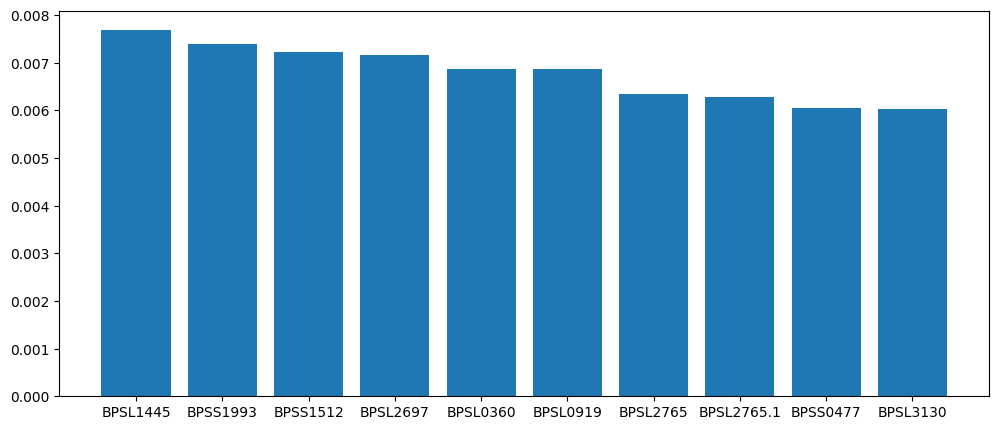

In [247]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(desc_lle_diff_score[:10],PCA_diff_score[:10])

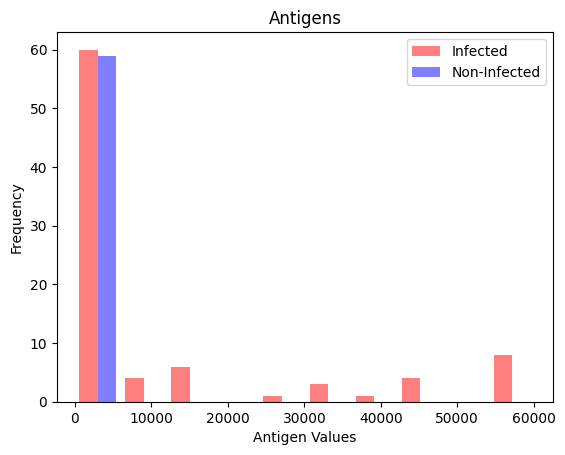

In [248]:
import matplotlib.pyplot as plt

plt.hist([infected['BPSS1525'], noninfected['BPSS1525']], color=['red', 'blue'], alpha=0.5, label=['Infected', 'Non-Infected'])
plt.title('Antigens')
plt.xlabel('Antigen Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

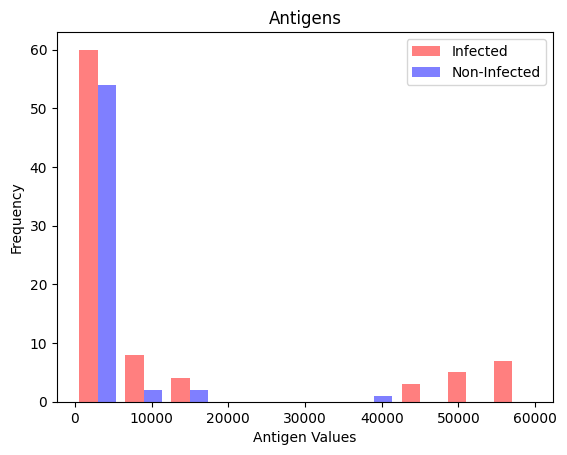

In [249]:
import matplotlib.pyplot as plt

infected_antigen = infected['BPSL1445'] 
noninfected_antigen = noninfected['BPSL1445'] 
plt.hist([infected['BPSL1445'] , noninfected['BPSL1445'] ], color=['red', 'blue'], alpha=0.5, label=['Infected', 'Non-Infected'])

plt.title('Antigens')
plt.xlabel('Antigen Values')
plt.ylabel('Frequency')
plt.legend()

plt.show()

1. Which antigen has the maximal MDS differential score, when we use `sklearn.manifold.MDS` with the additional parameter `random_state=40`?
2. Which antigen has the maximal LLE differential score?
3. For the antigen with maximal differential score for each method, plot a double histogram of the original values for the antigen. A double histogram    should contain two histograms 
   1. Histogram of the measuments of infected patients, and
   2. histogram of the measuments of noninfected patients
   
   in two different semi-transparent colors.

#### Using MDS and LLe methods, I get different antigens.

From the plot below we can check the similarities, and the most important diefferntial antigens

In [252]:
desc_lle_diff_score[0]

'BPSL1445'

In [253]:
desc_mds_diff_score[0]

'BPSS1525'

<BarContainer object of 10 artists>

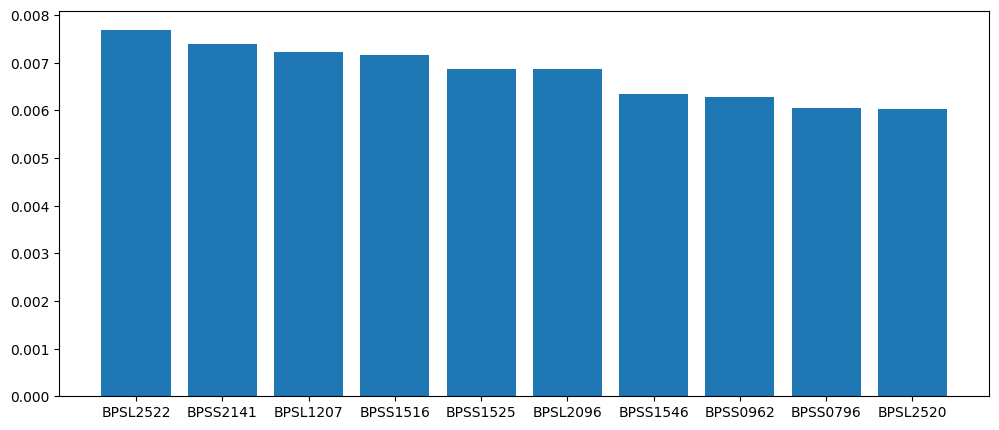

In [254]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(desc_PCA_diff_score[:10],PCA_diff_score[:10])

<BarContainer object of 10 artists>

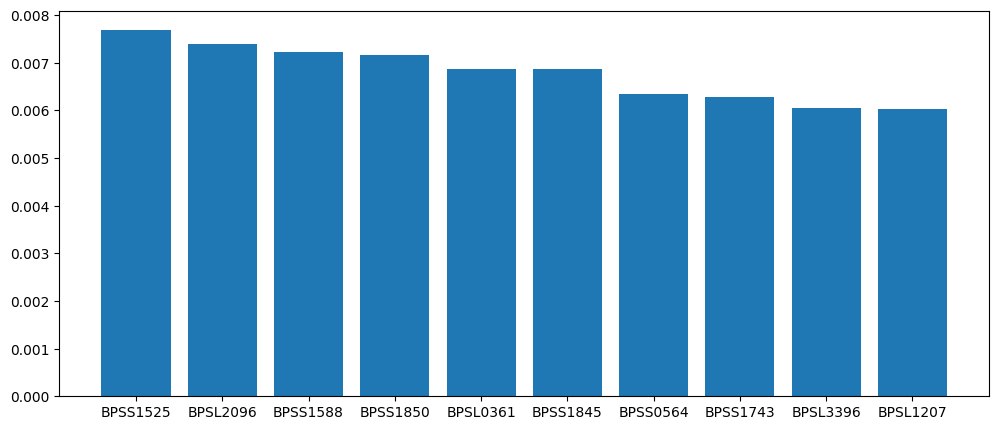

In [255]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(desc_mds_diff_score[:10],PCA_diff_score[:10])

<BarContainer object of 10 artists>

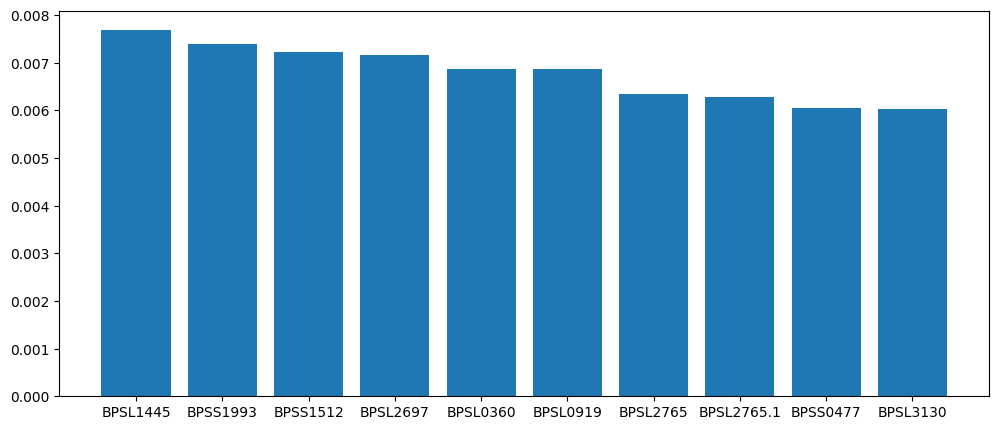

In [256]:
fig,ax = plt.subplots(figsize=(12,5))
ax.bar(desc_lle_diff_score[:10],PCA_diff_score[:10])